# Numerical Phenomena - PDEs

## Contents

- [Advection-Diffusion Equation](#advection_diffusion_equation)

## Advection-Diffusion Equation <a id="advection_diffusion_equation" />

Consider the classic advection-diffusion equation given by

$$ u_t + v u_x = \alpha u_{xx}, $$

where $v$ could be a superficial velocity, $\alpha$ a diffusion coefficient, and $u$ the concentration of some species. 

### Pure Advection

For $\alpha=0$, we know the solution:

$$ u(t,z) = u_0(z-vt)$$

In [8]:
# Imports
using LinearAlgebra, Plots, LaTeXStrings

# Defining the advection diffusion equation
function adv_diff_ODE(u, p, t)

    uBCs, v, α, A_1D_CDS, A_1D_UDS = p

    uzg_vec = copy(u)
    insert!(uzg_vec, 1, uBCs[1])
    push!(uzg_vec, u[end])

    du = ( -v.*A_1D_UDS*uzg_vec + α.*A_1D_CDS*uzg_vec )[2:end-1]

end

# Defining a simple ODE solver
function solve_ODE(ODE_fun, t_span, u0, t_eval, dt, p)

    t0, tf = t_span
    u = u0

    utz_mat = zeros(length(t_eval), length(u))
    utz_mat[1,:] = u
    i_teval = 2
    t = t0
    
    while t < tf
        du = ODE_fun(u, p, t)
        u += du * dt
        t += dt
        if t > t_eval[i_teval]
            utz_mat[i_teval,:] = copy(u)
            i_teval += 1
        end
    end

    return utz_mat
end

solve_ODE (generic function with 1 method)

In [11]:
# Problem specs
L = 1.
v = 1.
α = 0.0
uBCs = [1., 0.];        # BCs

# Spacial discretization
Nz = 100
dz = L / (Nz + 1)
uz_vec = ones(Nz);      # IC
A_1D_CDS = 1/(dz^2) .* Tridiagonal(ones(Nz+1), -ones(Nz+2), ones(Nz+1))
A_1D_UDS = 1/dz .* Tridiagonal(-ones(Nz+1), ones(Nz+2), zeros(Nz+1))
A_1D_UDS[end,:] = zeros(Nz+2);

p = uBCs, v, α, A_1D_CDS, A_1D_UDS;

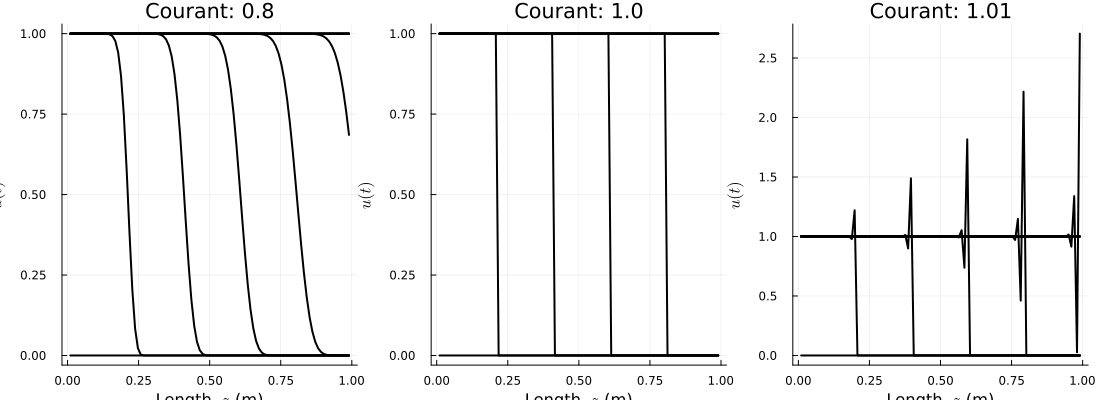

In [ ]:
## Test solver for different Courant numbers
Cus = [0.8, 1.0, 1.01]
plts = []

for Cu in Cus
    # Set time step to get desired Courant number
    dt = Cu*dz / v

    # Solving
    t_span = [0., 2.]
    u0 = zeros(Nz)
    t_eval = t_span[1]:0.2:t_span[end]
    utz_mat = solve_ODE(adv_diff_ODE, t_span, u0, t_eval, dt, p)

    # Plotting
    plt = plot(dz:dz:L-dz, utz_mat', legend=false, title="Courant: $Cu", xlabel=L"Length, $z$ (m)", ylabel=L"$u(t)$", 
               line=(2, :solid), c="black")
    push!(plts, plt)
end

## Plotting
plot(plots[1], plots[2], plots[3], layout=(1,3), size=(1100,400))

In [239]:
# Lax-Friedrichs

## Problem specs
L = 1.
v = 1.
α = 0.0
uz_vec = ones(Nz);      # IC
uBCs = [1., 0.];        # BCs

## Spacial discretization
Nz = 100
dz = L / (Nz + 1)

dl = -ones(Nz+1)./2; d = zeros(Nz+2); du = ones(Nz+1)./2
A_1D_LF = 1/dz .* Tridiagonal(dl, d, du);
A_1D_LF

102×102 Tridiagonal{Float64, Vector{Float64}}:
   0.0   50.5     ⋅      ⋅      ⋅   …     ⋅      ⋅      ⋅      ⋅     ⋅ 
 -50.5    0.0   50.5     ⋅      ⋅         ⋅      ⋅      ⋅      ⋅     ⋅ 
    ⋅   -50.5    0.0   50.5     ⋅         ⋅      ⋅      ⋅      ⋅     ⋅ 
    ⋅      ⋅   -50.5    0.0   50.5        ⋅      ⋅      ⋅      ⋅     ⋅ 
    ⋅      ⋅      ⋅   -50.5    0.0        ⋅      ⋅      ⋅      ⋅     ⋅ 
    ⋅      ⋅      ⋅      ⋅   -50.5  …     ⋅      ⋅      ⋅      ⋅     ⋅ 
    ⋅      ⋅      ⋅      ⋅      ⋅         ⋅      ⋅      ⋅      ⋅     ⋅ 
    ⋅      ⋅      ⋅      ⋅      ⋅         ⋅      ⋅      ⋅      ⋅     ⋅ 
    ⋅      ⋅      ⋅      ⋅      ⋅         ⋅      ⋅      ⋅      ⋅     ⋅ 
    ⋅      ⋅      ⋅      ⋅      ⋅         ⋅      ⋅      ⋅      ⋅     ⋅ 
   ⋮                                ⋱                         ⋮    
    ⋅      ⋅      ⋅      ⋅      ⋅         ⋅      ⋅      ⋅      ⋅     ⋅ 
    ⋅      ⋅      ⋅      ⋅      ⋅         ⋅      ⋅      ⋅      ⋅     ⋅ 
    ⋅      ⋅      ⋅  

In [240]:
function fun(uz_vec, param_vec)

    uBCs, v, α, dt, A_1D_CDS, A_1D_LF = param_vec

    uzg_vec = copy(uz_vec)
    insert!(uzg_vec, 1, uBCs[1])
    push!(uzg_vec, uz_vec[end])

    uz_vec = ( (uzg_vec[1:end-2] + uzg_vec[3:end])./2 ) + dt * ( -v.*A_1D_LF*uzg_vec )[2:end-1]

    return uz_vec
end


function solve_PDE(fun, t_span, u0, t_eval, param_vec)

    t0, tf = t_span
    uz_vec = u0
    uBCs, v, α, dt, A_1D_CDS, A_1D_LF = param_vec

    utz_mat = zeros(length(t_eval), length(uz_vec))
    utz_mat[1,:] = uz_vec
    i_teval = 2
    t = t0
    
    while t < tf

        uz_vec = fun(uz_vec, param_vec)


        t += dt
        if t > t_eval[i_teval]
            utz_mat[i_teval,:] = copy(uz_vec)
            i_teval += 1
        end
    end

    # Returns solution vector
    return utz_mat
end

solve_PDE (generic function with 1 method)

In [241]:
Cus = [0.8, 1.0, 1.01]
plots = []
for Cu in Cus
    dt = Cu*dz / v
    param_vec = [uBCs, v, α, dt, A_1D_CDS, A_1D_LF]

    ## Solving
    t_span = [0., 2.]
    u0 = zeros(Nz)
    t_eval = t_span[1]:0.2:t_span[end]
    utz_mat = solve_PDE(fun, t_span, u0, t_eval, param_vec);

    p = plot(dz:dz:L-dz, utz_mat', legend=false, title="Courant: $Cu", xlabel=L"Length, $z$ (m)", ylabel=L"$u(t)$")
    push!(plots, p)
end

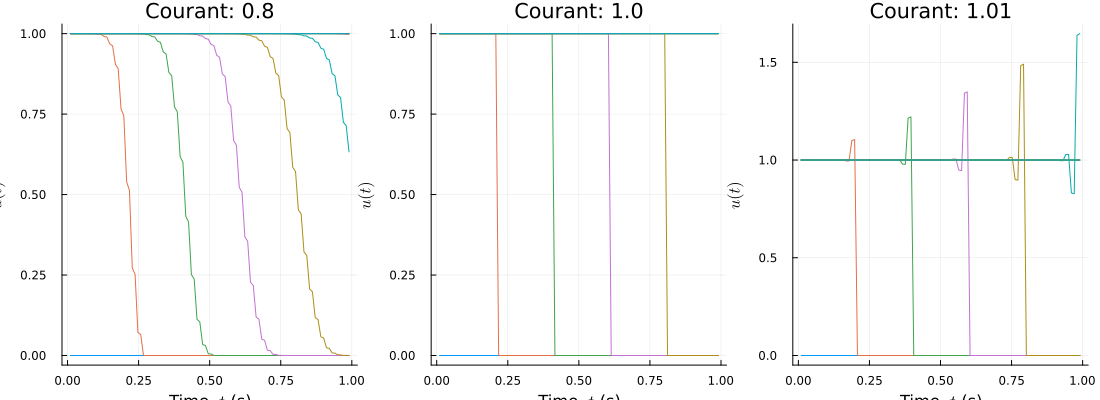

In [242]:
# Plotting
plot(plots[1], plots[2], plots[3], layout=(1,3), size=(1100,400))

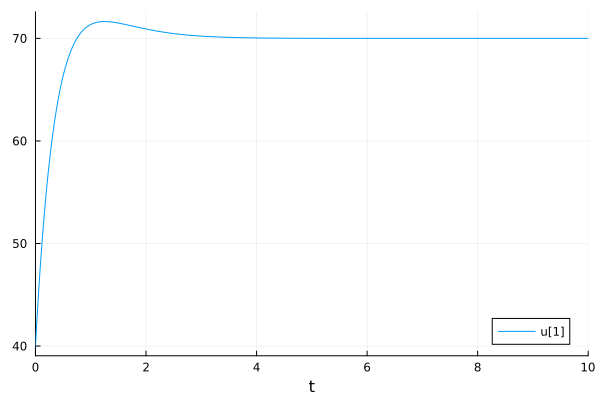

In [1]:
using DifferentialEquations, Plots

f_ODE(u, p, t) = -2*(u - 70 - 20*exp(-2*t))
tspan = (0., 10.)
u0 = 40.
prob = ODEProblem(f_ODE, u0, tspan)
sol = solve(prob)
plot(sol)

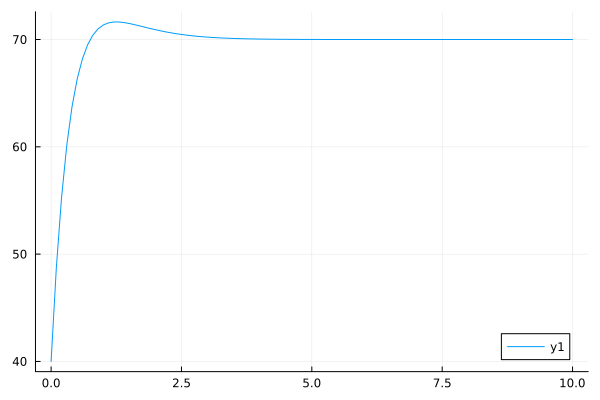

In [4]:
u_sol(t) = @. 10*(4t-3) * exp(-2t) + 70
t_vec = 0.:0.1:10.
plot(t_vec, u_sol(t_vec))